## 6-2. Qulacs を用いた variational quantum eigensolver (VQE) の実装

この節では、OpenFermion・PySCF を用いて求めた量子化学ハミルトニアンについて、Qulacs を用いてシミュレータ上で variational quantum eigensolver (VQE) を実行し、基底状態を探索する例を示す。

必要なもの
- qulacs
- openfermion
- openfermion-psi4
- pyscf
- scipy
- numpy

### 必要なパッケージのインストール・インポート

In [1]:
!pip install qulacs-gpu
!pip install openfermion
!pip install openfermionpsi4

    100% |████████████████████████████████| 133kB 6.3MB/s 
  Running setup.py bdist_wheel for qulacs-gpu ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done
  Stored in directory: /root/.cache/pip/wheels/9a/e8/85/96c72d5009128fdb28a8b0f5eac7bc04b9a60efe319bc7cf07
Successfully built qulacs-gpu
    100% |████████████████████████████████| 614kB 11.5MB/s 
    100% |████████████████████████████████| 348kB 28.4MB/s 
  Running setup.py bdist_wheel for openfermion ... - \ | done
  Stored in directory: /root/.cache/pip/wheels/c6/24/16/1ee82a50a11993a78c73f1fe208cd83c5c69d0930c1ca1817b
  Running setup.py bdist_wheel for pubchempy ... - done
  Stored in directory: /root/.cache/pip/wheels/10/4d/51/6b843681a9a5aef35f0d0fbce243de46f85080036e16118752
Successfully built openfe

In [3]:
!wget -c https://repo.continuum.io/archive/Anaconda3-5.1.0-Linux-x86_64.sh
!chmod +x Anaconda3-5.1.0-Linux-x86_64.sh
!bash ./Anaconda3-5.1.0-Linux-x86_64.sh -b -f -p /usr/local
!conda config --add channels http://conda.anaconda.org/psi4
!python -m conda install -y psi4

--2019-01-20 06:20:02--  https://repo.continuum.io/archive/Anaconda3-5.1.0-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.16.19.10, 104.16.18.10, 2606:4700::6810:130a, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.16.19.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 577996269 (551M) [application/x-sh]
Saving to: ‘Anaconda3-5.1.0-Linux-x86_64.sh’

Anaconda3-5.1.0-Lin 100%[===================>] 551.22M  98.4MB/s    in 5.9s    

2019-01-20 06:20:08 (92.8 MB/s) - ‘Anaconda3-5.1.0-Linux-x86_64.sh’ saved [577996269/577996269]

PREFIX=/usr/local
installing: python-3.6.4-hc3d631a_1 ...
Python 3.6.4 :: Anaconda, Inc.
installing: ca-certificates-2017.08.26-h1d4fec5_0 ...
installing: conda-env-2.6.0-h36134e3_1 ...
installing: intel-openmp-2018.0.0-hc7b2577_8 ...
installing: libgcc-ng-7.2.0-h7cc24e2_2 ...
installing: libgfortran-ng-7.2.0-h9f7466a_2 ...
installing: libstdcxx-ng-7.2.0-h7a57d05_2 ...
installing: bzip2-1.0.6-h9a117a8_

In [2]:
import sys, os
import qulacs
sys.path.append('/usr/local/lib/python3.6/site-packages/')

from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.transforms import get_sparse_operator
from openfermion.hamiltonians import MolecularData
from openfermionpyscf import run_pyscf
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

### ハミルトニアンを作る

前節と同様の手順で、ハミルトニアンを PySCF によって計算する。

In [4]:
basis = "sto-3g"
multiplicity = 1
charge = 0
distance  = 0.977
geometry = [["H", [0,0,0]],["H", [0,0,distance]]]
description  = "tmp"
molecule = MolecularData(geometry, basis, multiplicity, charge, description)
molecule = run_pyscf(molecule,run_scf=1,run_fci=1)
n_qubit = molecule.n_qubits
n_electron = molecule.n_electrons
fermionic_hamiltonian = get_fermion_operator(molecule.get_molecular_hamiltonian())
jw_hamiltonian = jordan_wigner(fermionic_hamiltonian)

### ハミルトニアンを qulacs ハミルトニアンに変換する

Qulacs では、ハミルトニアンのようなオブザーバブルは `Observable` クラスによって扱われる。OpenFermion のハミルトニアンを Qulacs の `Observable` に変換する関数 `create_observable_from_openfermion_text` が用意されているので、これを使えば良い。

In [5]:
from qulacs import Observable
from qulacs.observable import create_observable_from_openfermion_text
qulacs_hamiltonian = create_observable_from_openfermion_text(str(jw_hamiltonian))

### ansatz を構成する

Qulacs 上で量子回路を構成する。ここでは、量子回路は超伝導量子ビットによる実験 (A. Kandala et. al., Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets, Nature **549**, 242–246) で用いられたものを模して作った。

In [6]:
from qulacs import QuantumState, QuantumCircuit
from qulacs.gate import CZ, RY, RZ, merge

depth = n_qubit

In [19]:
def he_ansatz_circuit(n_qubit, depth, theta_list):
    """he_ansatz_circuit
    Returns hardware efficient ansatz circuit.

    Args:
        n_qubit (:class:`int`):
            the number of qubit used (equivalent to the number of fermionic modes)
        depth (:class:`int`):
            depth of the circuit.
        theta_list (:class:`numpy.ndarray`):
            rotation angles.
    Returns:
        :class:`qulacs.QuantumCircuit`
    """
    circuit = QuantumCircuit(n_qubit)
    for d in range(depth):
        for i in range(n_qubit):
            circuit.add_gate(merge(RY(i, theta_list[2*i+2*n_qubit*d]), RZ(i, theta_list[2*i+1+2*n_qubit*d])))
        for i in range(n_qubit//2):
            circuit.add_gate(CZ(2*i, 2*i+1))
        for i in range(n_qubit//2-1):
            circuit.add_gate(CZ(2*i+1, 2*i+2))
    for i in range(n_qubit):
        circuit.add_gate(merge(RY(i, theta_list[2*i+2*n_qubit*depth]), RZ(i, theta_list[2*i+1+2*n_qubit*depth])))
    
    return circuit

### VQE のコスト関数を定義する

5.1 章で説明した通り、VQE はパラメータ付きの量子回路 $U(\theta)$ から出力される状態 $|\psi(\theta)\rangle = U(\theta)|0\rangle$ に関するハミルトニアンの期待値
$$\langle H (\theta)\rangle = \langle\psi(\theta)|H|\psi(\theta)\rangle$$
を最小化することで、近似的な基底状態を得る。以下にこのハミルトニアンの期待値を返す関数を定義する。

In [13]:
def cost(theta_list):
    state = QuantumState(n_qubit) #|00000> を準備
    circuit = he_ansatz_circuit(n_qubit, depth, theta_list) #量子回路を構成
    circuit.update_quantum_state(state) #量子回路を状態に作用
    return qulacs_hamiltonian.get_expectation_value(state) #ハミルトニアンの期待値を計算

### VQE を実行する

準備ができたので、VQE を実行する。最適化には scipy に実装されている BFGS 法を用い、初期パラメータはランダムに選ぶ。数十秒で終わるはずである。

In [31]:
cost_history = []
init_theta_list = np.random.random(2*n_qubit*(depth+1))*1e-1
cost_history.append(cost(init_theta_list))
method = "BFGS"
options = {"disp": True, "maxiter": 50, "gtol": 1e-6}
opt = minimize(cost, init_theta_list,
               method=method,
               callback=lambda x: cost_history.append(cost(x)))

実行結果をプロットしてみると、正しい解に収束していることが見て取れる。

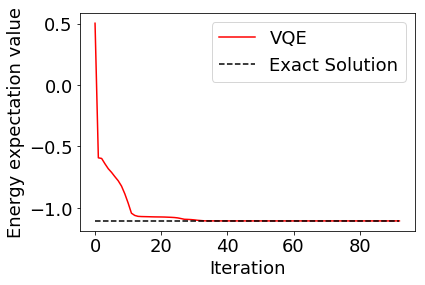

In [35]:
plt.rcParams["font.size"] = 18
plt.plot(cost_history, color="red", label="VQE")
plt.plot(range(len(cost_history)), [molecule.fci_energy]*len(cost_history), linestyle="dashed", color="black", label="Exact Solution")
plt.xlabel("Iteration")
plt.ylabel("Energy expectation value")
plt.legend()
plt.show()

興味のある読者は、水素原子間の距離 `distance` を様々に変えて基底状態を計算し、水素分子が最も安定になる原子間距離を探してみてほしい。（ansatzの性能にもよるが、およそ0.74オングストロームになるはずである）